In [71]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def process_image_and_scale_centers(img, downsample_resolution=8, min_area=1000, max_area=50000, min_hole_area=100000):
    """
    Downsamples an input image, applies a multi-step segmentation and filtering 
    pipeline (Otsu's thresholding, connected component analysis, noise removal, 
    hole filling, and skeletonization) to find the center points of blobs, 
    and then scales the center coordinates back to the original image resolution.

    Args:
        img (np.array): The input BGR image (original size).
        downsample_resolution (int): Factor by which to reduce the image size. 
                                     e.g., 8 means 1/8th the size.
        min_area (int): Minimum pixel area for a black blob to be considered a worm.
        max_area (int): Maximum pixel area for a black blob (to exclude background artifacts).
        min_hole_area (int): Maximum pixel area for a white region to be considered a 
                             'hole' and filled with black.

    Returns:
        list: A list of tuples, where each tuple contains (cx, cy) center coordinates 
              scaled to the original image resolution.
    """
    
    # 1. Downsample the image
    original_height, original_width = img.shape[:2]
    new_width = original_width // downsample_resolution
    new_height = original_height // downsample_resolution
    
    downsampled_img = cv2.resize(img, (new_width, new_height))
    
    print("Original image shape:", img.shape)
    print("Downsampled image shape:", downsampled_img.shape)

    # 2. Convert to grayscale and apply Gaussian blur
    if len(downsampled_img.shape) == 3:
        gray_img = cv2.cvtColor(downsampled_img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = downsampled_img

    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # 3. Otsu's thresholding
    _, initial_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4. Filter out small and large black blobs (noise/broken worms/background)
    inv_mask = 255 - initial_mask
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inv_mask, connectivity=8)

    filtered_mask = initial_mask.copy()
    
    for i in range(1, num_labels):  # Skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Filter out small blobs (noise/broken worms)
        if area < min_area:
            filtered_mask[labels == i] = 255  # Set to white
        
        # Filter out huge blobs (large background artifacts)
        elif area > max_area:
            filtered_mask[labels == i] = 255  # Set to white

    # 5. Fill small white holes in the remaining black blobs
    filled_mask = filtered_mask.copy()
    num_labels_white, labels_white, stats_white, centroids_white = cv2.connectedComponentsWithStats(filled_mask, connectivity=8)
    
    for i in range(1, num_labels_white):
        if stats_white[i, cv2.CC_STAT_AREA] < min_hole_area:
            filled_mask[labels_white == i] = 0  # Fill with black

    # 6. Find centers using skeletonization
    mask = filled_mask
    num_labels_blobs, labels_blobs, stats_blobs, centroids_blobs = cv2.connectedComponentsWithStats(255 - mask, connectivity=8)
    blob_centers = []
    
    for i in range(1, num_labels_blobs):
        area = stats_blobs[i, cv2.CC_STAT_AREA]
        
        if area >= min_area:
            blob_mask = (labels_blobs == i).astype(np.uint8)
            
            # Use skeletonization to find a representative center point
            skeleton = skeletonize(blob_mask)
            skeleton_points = np.where(skeleton)
            
            if len(skeleton_points[0]) > 0:
                # Find the center of mass of the skeleton points
                cy_mean = np.mean(skeleton_points[0])
                cx_mean = np.mean(skeleton_points[1])
                
                # Find the skeleton pixel closest to this center of mass
                distances = np.sqrt((skeleton_points[1] - cx_mean)**2 + (skeleton_points[0] - cy_mean)**2)
                closest_idx = np.argmin(distances)
                
                cx_actual = skeleton_points[1][closest_idx]
                cy_actual = skeleton_points[0][closest_idx]
                
                blob_centers.append((cx_actual, cy_actual))

    # 7. Scale the blob centers back to the original image coordinates
    scaled_blob_centers = [(int(cx * downsample_resolution), int(cy * downsample_resolution)) for cx, cy in blob_centers]

    return scaled_blob_centers




In [69]:
import os
from tqdm import tqdm
def get_cropped_pixels(img, thresh=254):
    """
    Crop an image to remove black or near-black borders by finding the bounding box
    of pixels above the threshold in any channel.

    Parameters:
    - img: numpy array (H, W, C) - the input image
    - thresh: int (0-255) - threshold below which pixels are considered "black"

    Returns:
    - x0, y0, x1, y1: coordinates of the cropped bounding box, or None if no content found
    """
    # Create mask for pixels that are not black (above thresh in any channel)
    mask = (img > thresh).any(axis=2)
    if mask.any():
        ys, xs = np.where(mask)
        y0, y1 = ys.min(), ys.max()
        x0, x1 = xs.min(), xs.max()
        return x0, y0, x1, y1
    return None
    
def shrink_video(video_dir, save_dir):
    """Shrink video frames by cropping black borders."""
    if os.path.exists(save_dir) and not os.path.isdir(save_dir):
        raise NotADirectoryError(f"{save_dir} exists and is not a directory")
    os.makedirs(save_dir, exist_ok=True)

    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".png"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0].split('_')[-1]))

    # gets the overall cropping box across all frames
    min_x0, min_y0 = float('inf'), float('inf')
    max_x1, max_y1 = -1, -1
    for frame_name in tqdm(frame_names, desc="Calculating cropping box"):
        img_fp = os.path.join(video_dir, frame_name)
        img = cv2.imread(img_fp)  # BGR
        x0, y0, x1, y1 = get_cropped_pixels(img, thresh=254)
        if x0 is not None:
            min_x0 = min(min_x0, x0)
            min_y0 = min(min_y0, y0)
            max_x1 = max(max_x1, x1)
            max_y1 = max(max_y1, y1)
        # print(f"Frame {frame_name} | x0 {x0} (min {min_x0}) | y0 {y0} (min {min_y0}) | x1 {x1} (max {max_x1}) | y1 {y1} (max {max_y1})", end="\r")
    
    # crop all frames using the overall cropping box
    for i, frame_name in tqdm(enumerate(frame_names), desc="Cropping and saving frames"):
        img_fp = os.path.join(video_dir, frame_name)
        save_fp = os.path.join(save_dir, f"{i}.jpg")
        img = cv2.imread(img_fp)  # BGR
        cropped_img = img[min_y0:max_y1, min_x0:max_x1]
        cv2.imwrite(save_fp, cropped_img)


In [70]:
video_dir = "ordered_thumbnails"
shrink_video(video_dir, f"{video_dir}_cropped")

Calculating cropping box: 100%|██████████| 387/387 [19:04<00:00,  2.96s/it]  
Cropping and saving frames: 387it [2:22:02, 22.02s/it] 


Original image shape: (5072, 8823, 3)
Downsampled image shape: (634, 1102, 3)
Scaled blob centers (original image coordinates): [(4216, 1592), (5184, 1952), (7904, 2024), (3792, 2832), (2600, 3088), (5992, 2992), (2288, 2768), (7080, 2976), (5192, 3192), (7976, 3136), (3624, 3368), (6128, 3576), (1960, 3600)]


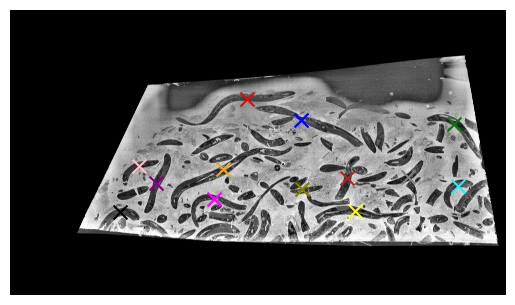

In [77]:
# `video_dir` a directory of PNG frames with filenames like `<frame_index>.png`
import cv2
import os
import matplotlib.pyplot as plt
video_dir = "ordered_thumbnails_cropped"
frame_idx = 0
frame_name = f"{frame_idx}.jpg"
img = cv2.imread(os.path.join(video_dir, frame_name))


scaled_blob_centers = process_image_and_scale_centers(img, downsample_resolution=8)
print("Scaled blob centers (original image coordinates):", scaled_blob_centers)
plt.imshow(img)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'black', 'lime', 'teal', 'navy']
for i, (cx, cy) in enumerate(scaled_blob_centers):
    plt.scatter(cx, cy, color=colors[i % len(colors)], marker='x', s=100)
plt.axis('off')
plt.show()

In [78]:
# select the device for computation
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [79]:
from sam2.build_sam import build_sam2_video_predictor

model_size = "base"
if model_size == "tiny":
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_tiny.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
elif model_size == "small":
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_small.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"
elif model_size == "large":
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
else:
    sam2_checkpoint = "./checkpoints/sam2.1_hiera_base_plus.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
print(f"Using SAM 2 model size: {model_size}")
print(f"Checkpoint: {sam2_checkpoint} Model config: {model_cfg}")

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
inference_state = predictor.init_state(video_path=video_dir)

Using SAM 2 model size: base
Checkpoint: ./checkpoints/sam2.1_hiera_base_plus.pt Model config: configs/sam2.1/sam2.1_hiera_b+.yaml


frame loading (JPEG): 100%|██████████| 387/387 [02:26<00:00,  2.64it/s]


In [80]:
ann_frame_idx = 0  # the frame index we interact with

num_objs_to_track = len(scaled_blob_centers)
for i, center in enumerate(scaled_blob_centers[:num_objs_to_track]):
    ann_obj_id = i + 1  # give a unique id to each object we interact with (it can be any integers)
    
    # Use each center as a separate point for a separate object
    points = np.array([center], dtype=np.float32)  # for labels, `1` means positive click and `0` means negative click
    labels = np.ones(points.shape[0], dtype=np.int32)
    
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )

/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


torch.Size([13, 1, 5072, 8823])


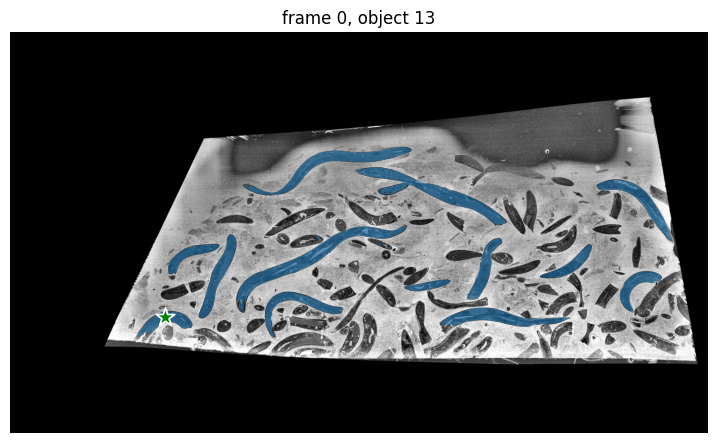

In [81]:
print(out_mask_logits.shape)  # (num_interacted_objects, H, W)
combined_mask = (out_mask_logits > 0.0).any(dim=0).squeeze().cpu().numpy()
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}, object {ann_obj_id}")
plt.imshow(img)
show_points(points, labels, plt.gca())
show_mask(combined_mask, plt.gca(), obj_id=0)
plt.axis('off')
plt.show()


In [82]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video:  30%|███       | 117/387 [44:01<1:41:36, 22.58s/it]


RuntimeError: MPS backend out of memory (MPS allocated: 14.93 GiB, other allocations: 1.05 GiB, max allowed: 18.13 GiB). Tried to allocate 2.17 GiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [83]:
def create_segmentation_video(video_segments, video_dir, output_path="segmentation_results.mp4", fps=5):
    import cv2
    import os
    import tempfile
    from PIL import Image
    import matplotlib.pyplot as plt

    num_frames = len(video_segments)
    frame_images = []

    # Create a temporary directory to store frame images
    temp_dir = tempfile.mkdtemp()

    for out_frame_idx in range(num_frames):
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, f"{out_frame_idx}.jpg")))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.axis('off')
        
        # Save the figure as an image
        frame_path = os.path.join(temp_dir, f"frame_{out_frame_idx:04d}.png")
        plt.savefig(frame_path)
        plt.close()
        frame_images.append(frame_path)

    # Now create the MP4 video from the saved images
    frame = cv2.imread(frame_images[0])
    height, width, layers = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for image_path in frame_images:
        video.write(cv2.imread(image_path))

    video.release()

    # Clean up temporary images
    for image_path in frame_images:
        os.remove(image_path)
    os.rmdir(temp_dir)

    print(f"Video saved as {output_path}")

# Call the function with existing variables

In [ ]:
create_segmentation_video(video_segments, video_dir, output_path=f"{model_size}_{video_dir}_segmentation_results.mp4", fps=5)

/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/huayinluo/Documents/code/zhenlab/zhenvenv/lib/python3.13/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


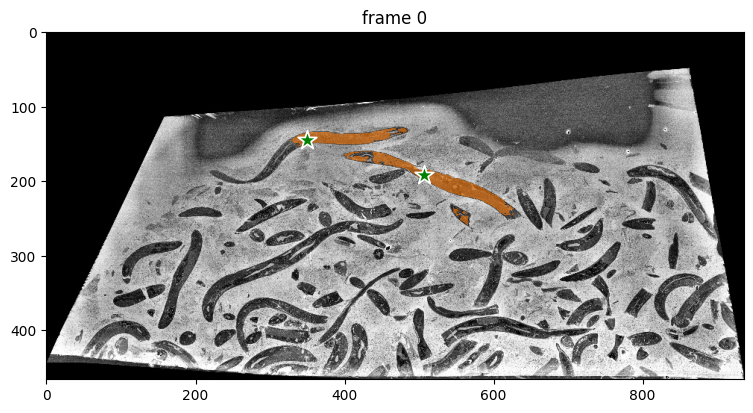

In [34]:
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
from PIL import Image
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, f"{ann_frame_idx}.jpg")))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])